### Disease balanced input data to RF (run2): analysis of classifier resutls

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, average_precision_score, accuracy_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
def fpr_tpr(mat):
    '''
    Function takes in a confusion matrix
    Retunr false positive rate (FPR) and true positive (TPR)
    
    Only works for binary cases
    '''
    tn, fp, fn, tp = mat.ravel()
    if len(mat.shape) !=2:
        raise ValueError('Function can only handle binary classification cases')
    tot = mat.sum(axis=1) # total negative(0) and positive(1) labels
    FPR = fp/tot[0]
    TPR = tp/tot[1]
        
    return FPR,TPR

In [2]:
results = np.load('./results/RF_results_run2.npy').item()

In [3]:
results.keys()

dict_keys(['test_labels', 'pred_labels', 'pred_proba', 'acc', 'oob_score', 'model', 'average_precision', 'precision', 'recall', 'genes', 'importances', 'test_samples'])

In [4]:
print('Accuracy achieved: %.3f'%results['acc'])

Accuracy achieved: 0.971


In [5]:
print('Average precision achieved: %.3f'%results['average_precision'])

Average precision achieved: 0.997


In [6]:
mismatch = results['test_labels'] != results['pred_labels']
mismatch_idx = [i for i,e in enumerate(mismatch) if e ]

In [7]:
misclassified_df = pd.DataFrame(results['pred_proba'][mismatch_idx], index=results['test_samples'][mismatch_idx], columns=['PolyA', 'Ribo'])


### List of miscalssified samples

In [8]:
misclassified_df

,PolyA,Ribo
THR20_0514_S01,0.312206,0.687794
THR37_1308_S01,0.390402,0.609598
THR11_0263_S01,0.412759,0.587241
THR33_1007_S01,0.114412,0.885588


In [9]:
results.keys()

dict_keys(['test_labels', 'pred_labels', 'pred_proba', 'acc', 'oob_score', 'model', 'average_precision', 'precision', 'recall', 'genes', 'importances', 'test_samples'])

In [10]:
mat = confusion_matrix(results['test_labels'], results['pred_labels'])

### Confusion matrix shows good separation between the two calsses
* Class 0: PolyA libraries
* Class 1: Ribo-deplete libraries
* 4 PolyA samples misclassified as Ribo-deplete

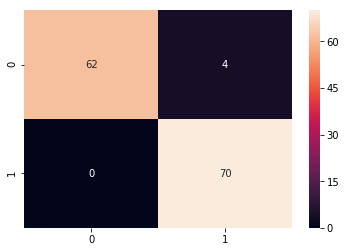

In [11]:
sns.heatmap(mat, annot=True)

In [58]:
fpr, tpr = fpr_tpr(mat)
print('FPR = {:.3f}, TPR = {:.3f}'.format(fpr, tpr))

FPR = 0.061, TPR = 1.000


In [12]:
importances = zip(results['importances'], results['genes'])

In [13]:
importances = sorted(importances, key = lambda x:x[0], reverse=True)


In [14]:
scores = list(map(lambda x:x[0], importances[:20]))
genes = list(map(lambda x:x[1], importances[:20]))

### Gene importance determined by RF classifier

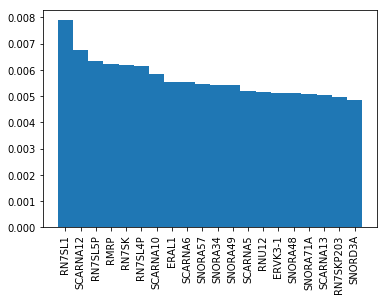

In [15]:
plt.bar(np.arange(len(scores)), scores, width=1)
plt.xticks(labels=genes, ticks=np.arange(len(scores)), rotation=90)
plt.show()
plt.close()

In [16]:
with open('/mnt/RiboVsPolyA/results/RF_gene_rank_run2.tsv', 'w') as f:
    f.write('Gene\tScore\n')
    for i in range(len(scores)):
        score = scores[i]
        gene = genes[i]
        f.write(gene+'\t'+str(score)+'\n')
        
    

### Attempting to improve probability threshold

Text(0.5, 1.0, 'Probability of being Ribo')

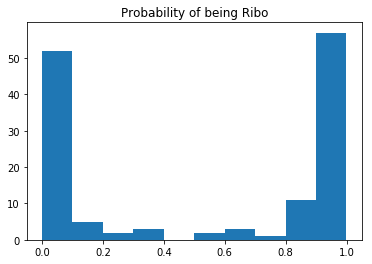

In [17]:
plt.hist(results['pred_proba'][:,1])
plt.title('Probability of being Ribo')

<Figure size 720x720 with 0 Axes>

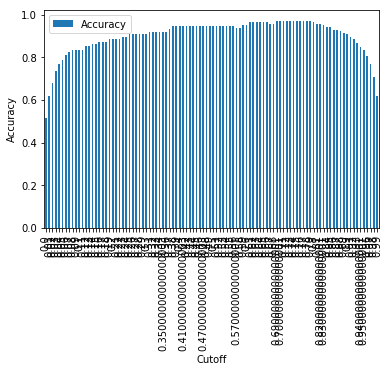

Best cutoff: 0.6900000000000001
Best accuracy: 0.9720557788332724


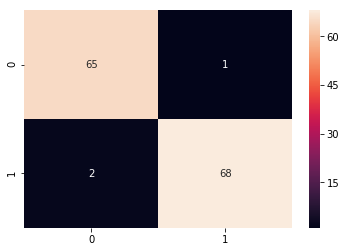

In [60]:
# optimize for negative label

accuracy_df=pd.DataFrame()
best_score=None
best_cutoff=None
best_pred=None
for cutoff in np.arange(0,1,0.01):

    test_pred_classes=[]
    for i in results['pred_proba'][:,1]:
        if i>=cutoff:
            test_pred_classes+=[1]
        else:
            test_pred_classes+=[0]
            
    score=average_precision_score(results['test_labels'],test_pred_classes )
    accuracy_df.loc[cutoff, 'Accuracy']=score
    #storing predictions with best accuracy score
    if best_score is None or score>best_score:
        best_score=score
        best_cutoff=cutoff
        best_pred=test_pred_classes


plt.figure(figsize=(10,10))
accuracy_df.plot(kind='bar')
plt.xlabel('Cutoff')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

plt.show()
plt.close()
print('Best cutoff: {}'.format(best_cutoff))
print('Best accuracy: {}'.format(best_score))

# print(accuracy_df.describe())

mat_2 = confusion_matrix(results['test_labels'], best_pred)
sns.heatmap(mat_2, annot=True)

In [61]:
fpr, tpr = fpr_tpr(mat_2)
print('FPR = {:.3f}, TPR = {:.3f}'.format(fpr, tpr))

FPR = 0.015, TPR = 0.971


### After optimizing the cutoff:
* FPR dropped from 0.06 to 0.015
* TPR also